<a href="https://colab.research.google.com/github/sutummala/selfQCNet/blob/main/QC_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgpm2:amd64.
(Reading database ... 155506 files and directories currently installed.)
Preparing to unpack .../libgpm2_1.20.7-5_amd64.deb ...
Unpacking libgpm2:amd64 (1.20.7-5) ...
Selecting previously unselected package w3m.
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up libgpm2:amd64 (1.20.7-5) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc

In [ ]:
# normalizing the input to have values between zero and one to make them suitable for further analysis
def normalize(input):
  norm_input = []
  print(f'shape of input is {np.shape(input[0])}')
  for i in range(np.shape(input)[0]):
    norm_in = (input[i]-np.min(input[i]))/(np.max(input[i])-np.min(input[i]))
    norm_input.append(norm_in)
  return np.array(norm_input)

In [ ]:
def crop_input(input, d_s_factor):
  
  if d_s_factor == 2:
    input = input[:, 6:86, 6:102, 6:86]
  elif d_s_factor == 4:
    input = input[:, 3:43, 4:52, 3:43]

  return input

In [ ]:
t1_align = np.load('/content/drive/MyDrive/Datasets/unsupervisedQC/T2-mni-dsf2.npy')
t1_align = np.float32(t1_align)
t1_align = crop_input(t1_align, 2)
t1_align = np.expand_dims(t1_align, axis = -1)

print('values before normalization', np.min(t1_align[0]), np.max(t1_align[0]))
t1_align_norm = normalize(t1_align)
print(t1_align_norm.shape)
print('values after normalization', np.min(t1_align_norm[0]), np.max(t1_align_norm[0]))
#print(t1_align_norm)

values before normalization -206.0 2301.0
shape of input is (80, 96, 80, 1)
(400, 80, 96, 80, 1)
values after normalization 0.0 1.0


In [ ]:
activation = tf.keras.activations.relu
kernal_initializer = tf.keras.initializers.glorot_normal
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
def create_model_single_conv_noupsamp(input_shape):
  input_layer = Input(shape=input_shape, dtype="float32", name="INPUT")

  x = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(input_layer)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  x = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  volumeSize = K.int_shape(x)
  x = Flatten()(x)

  x = Dense(256, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal)(x)

  x = Dense(128, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal, name="CODE")(x)

  x = Dense(256, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal)(x)

  x = Dense(np.prod(volumeSize[1:]), kernel_initializer=tf.keras.initializers.glorot_normal)(x)

  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3], volumeSize[4]))(x)

  x = Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = Conv3D(1, (3, 3, 3), strides=(1, 1, 1),  padding="same", kernel_initializer=kernal_initializer, name = "OUTPUT")(x)
  x = Activation(tf.keras.activations.sigmoid)(x)

  autoencoder = Model(input_layer, x)
  autoencoder.summary()

  print("Model created successfully")
  return autoencoder

In [ ]:
input_shape = (t1_align_norm.shape[1], t1_align_norm.shape[2], t1_align_norm.shape[3], 1)
autoencoder = create_model_single_conv_noupsamp(input_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 80, 96, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 80, 96, 80, 32)    896       
                                                                 
 batch_normalization (BatchN  (None, 80, 96, 80, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 96, 80, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 40, 48, 40, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 48, 40, 64)    55360 

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), loss = tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(t1_align_norm, t1_align_norm, validation_split = 0.1, batch_size = 8, epochs = 20, shuffle = True)

Epoch 1/20
45/45 [==============================] - 36s 549ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 2/20
45/45 [==============================] - 24s 540ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 3/20
45/45 [==============================] - 24s 539ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 4/20
45/45 [==============================] - 24s 540ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 5/20
45/45 [==============================] - 24s 539ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 6/20
45/45 [==============================] - 24s 540ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 7/20
45/45 [==============================] - 24s 540ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 8/20
45/45 [==============================] - 24s 539ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 9/20
45/45 [==============================] - 24s 541ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 10/20
45/45 [==============================] - 24s 540ms/step - loss: 0.0058 - val_lo

In [ ]:
losses_train = [] 
for i in range(np.shape(t1_align_norm)[0]):
  predicted_train = autoencoder.predict(t1_align_norm[i:i+1])
  losses_train.append(np.mean(np.square(predicted_train-t1_align_norm[i:i+1])))
print(losses_train)
threshold = np.mean(losses_train)+3*np.std(losses_train)
print(threshold)

[0.0044893157, 0.0061429334, 0.0048373216, 0.0037853739, 0.0071039214, 0.0050125467, 0.004714354, 0.0039594118, 0.0047982824, 0.0034688204, 0.0055806353, 0.003928825, 0.0053878813, 0.005408442, 0.005844537, 0.004961872, 0.003585929, 0.0049945107, 0.0064595537, 0.0053032, 0.0068378695, 0.004727375, 0.004792953, 0.0060086115, 0.0049971417, 0.0060766996, 0.005267987, 0.005499967, 0.006916767, 0.006043941, 0.007545243, 0.0043568653, 0.004537262, 0.00509373, 0.0047769616, 0.0034523762, 0.0060648522, 0.005483669, 0.004035857, 0.0040133256, 0.008417505, 0.0035468228, 0.005598655, 0.005339415, 0.0053682798, 0.0030805606, 0.0044600954, 0.004917002, 0.0068403957, 0.005655526, 0.006533859, 0.0057053706, 0.00397232, 0.0046246336, 0.0063754255, 0.006458958, 0.0047356654, 0.006847981, 0.0048084124, 0.0047307517, 0.005349388, 0.0059185177, 0.005783841, 0.0052019376, 0.005838398, 0.0052733105, 0.008556858, 0.0058961334, 0.0058981436, 0.0055798767, 0.0050064255, 0.0033946375, 0.005235528, 0.0061766854,

In [ ]:
predicted_train_all = autoencoder.predict(t1_align_norm)
losses_train_all = (np.square(predicted_train_all - t1_align_norm)).mean(axis=(1,2,3,4))
#print(losses_train_all)
threshold = np.mean(losses_train_all)+np.std(losses_train_all)
print(threshold)

In [ ]:
#predicted_validation_all = autoencoder.predict(t1_align_norm)
#losses_validation_all = (np.square(predicted_validation_all - t1_align_norm)).mean(axis=(1,2,3,4))
#print(losses_validation_all)
wrong_predicts = 0
for loss in losses_train:
  if loss >= threshold:
    wrong_predicts += 1
accuracy = (len(losses_train)-wrong_predicts)/(len(losses_train))
print(f'accuracy in identifying the correct alignments: {accuracy*100} percent')

accuracy in identifying the correct alignments: 99.25 percent


In [ ]:
def test_autoencoder(test):
  test = crop_input(test, 2)
  test = normalize(test)
  test = np.expand_dims(test, axis = -1)

  losses_test = [] 

  for i in range(np.shape(test)[0]):
    predicted_test = autoencoder.predict(test[i:i+1])
    losses_test.append(np.mean(np.square(predicted_test-test[i:i+1])))
  #predicted_fail = autoencoder.predict(t1_test)
  #losses_fail = (np.square(predicted_fail - t1_test)).mean(axis=(1,2,3,4))
  wrong_predicts = 0
  for loss in losses_test:
    if loss >= threshold:
      wrong_predicts += 1
  accuracy = (len(losses_test)-wrong_predicts)/(len(losses_test))
  print(f'accuracy in identifying the  misalignments: {accuracy*100} percent')

  return losses_test

In [ ]:
#abide_mni = np.load('/content/drive/MyDrive/Datasets/unsupervisedQC/T1-mni-dsf2-abide.npy')
#losses_abide = test_autoencoder(abide_mni)
#print(f'All losses: {losses_abide}')
#print(f'Mean loss: {np.mean(losses_abide)}')

#abide_mni_failed = np.load('/content/drive/MyDrive/Datasets/unsupervisedQC/T1-mni-dsf2-abide-failed.npy')
#losses_abide_fail = test_autoencoder(abide_mni_failed)
#print(f'All losses: {losses_abide_fail}')
#print(f'Mean loss: {np.mean(losses_abide_fail)}')

ixi_mni = np.load('/content/drive/MyDrive/Datasets/UnsupervisedQC/T1-mni-dsf2-HH.npy')
losses_ixi = test_autoencoder(ixi_mni)
print(f'All losses: {losses_ixi}')
print(f'Mean loss: {np.mean(losses_ixi)}')

ixi_mni_failed = np.load('/content/drive/MyDrive/Datasets/UnsupervisedQC/T1-mni-dsf2-ixi-failed.npy')
losses_ixi_fail = test_autoencoder(ixi_mni_failed)
print(f'All losses: {losses_ixi_fail}')
print(f'Mean loss: {np.mean(losses_ixi_fail)}')

shape of input is (80, 96, 80)
accuracy in identifying the  misalignments: 0.0 percent
All losses: [0.015571251, 0.012531814, 0.01675312, 0.014505992, 0.012851728, 0.017231612, 0.011610996, 0.015371541, 0.013561511, 0.013174829, 0.012792616, 0.013233898, 0.014615626, 0.0124765225, 0.012978543, 0.011891813, 0.011117395, 0.020562336, 0.012802289, 0.0149080735, 0.011106787, 0.0145768225, 0.0139752105, 0.014462003, 0.011441875, 0.011716042, 0.016765134, 0.015301266, 0.014149273, 0.012441763, 0.015937617, 0.013577108, 0.013804994, 0.012244515, 0.014418076, 0.011877601, 0.01479184, 0.012452505, 0.0134919025, 0.015711064, 0.012051708, 0.0136723835, 0.011774419, 0.0128205065, 0.01926841, 0.011112643, 0.013012304, 0.014101977, 0.014722433, 0.015006075, 0.014189138, 0.013648078, 0.011367773, 0.016370509, 0.021599004, 0.014660462, 0.01185351, 0.015265522, 0.013868481, 0.015594168, 0.017550321, 0.012113098, 0.013738162, 0.014123264, 0.013516725, 0.014477509, 0.012079426, 0.016867403, 0.013894531, 

In [ ]:
indices_T1_align = [10, 14, 18, 19, 21, 22, 23, 24, 25, 26, 28]
indices_T1_mni = [2, 6, 7, 8, 9, 10, 21, 29]
indices_T2_align = [1, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 27, 28, 30, 31]
indices_T2_mni = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 20, 21, 24, 27, 29, 30, 31]

In [ ]:
actual_failures = []
for index in indices_T2_mni:
  actual_failures.append(losses_ixi_fail[index])

print(actual_failures)
print(np.mean(actual_failures))

[0.02997448, 0.016187035, 0.025841583, 0.030743757, 0.023037288, 0.014290716, 0.0137272775, 0.013848701, 0.012831818, 0.02428404, 0.01468209, 0.03131163, 0.031171294, 0.031314906, 0.03332436, 0.01554757, 0.014090244, 0.033547733, 0.022200705, 0.013372619, 0.015582716, 0.025810005]
0.022123752


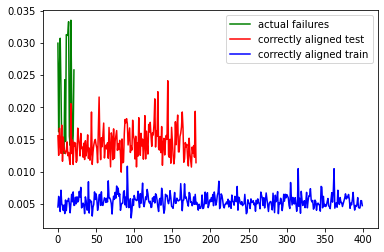

In [ ]:
import matplotlib.pyplot as plt

plt.plot(actual_failures, 'g')
plt.plot(losses_ixi, 'r')
plt.plot(losses_train, 'b')
plt.legend(['actual failures', 'correctly aligned test', 'correctly aligned train'])
plt.show()